In [1]:
import os
import numpy as np
from PIL import Image
import h5py
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Configuration
input_dir = 'C:/Users/User/Desktop/TPR 6223/project/bridge_dataset'  # image folders by bridge name
target_size = (128, 128)  # resize dimensions (width, height)
output_file = 'C:/Users/User/Desktop/TPR 6223/project/preprocessed_dataset/bridge_dataset.h5'

# Prepare data containers
X = []        # image data
y = []        # labels
label_map = {}  # bridge name → numeric label
class_counts = defaultdict(int)

# Assign label numbers to folder names
for label_id, folder_name in enumerate(sorted(os.listdir(input_dir))):
    folder_path = os.path.join(input_dir, folder_name)
    if not os.path.isdir(folder_path):
        continue
    label_map[folder_name] = label_id

    for image_name in os.listdir(folder_path):
        try:
            # Load, convert to grayscale, resize
            img_path = os.path.join(folder_path, image_name)
            img = Image.open(img_path).convert('L')
            img = img.resize(target_size)

            # Convert to NumPy array and normalize to [0, 1]
            img_array = np.asarray(img, dtype=np.float32) / 255.0

            # Add to dataset
            X.append(img_array)
            y.append(label_id)
            class_counts[folder_name] += 1

        except Exception as e:
            print(f"Failed to process {img_path}: {e}")

# Convert to numpy arrays and flatten for KNN
X = np.array(X).reshape(len(X), -1)  # (N, 16384)
y = np.array(y)

# Save to HDF5
os.makedirs(os.path.dirname(output_file), exist_ok=True)
with h5py.File(output_file, 'w') as hf:
    hf.create_dataset('images', data=X)
    hf.create_dataset('labels', data=y)

# Display basic info
print("Dataset saved to:", output_file)
print("\nTotal loaded {} images".format(len(X)))
print("\nImage counts per bridge class:")
for bridge, count in class_counts.items():
    print(f"  {bridge}: {count} images")

print("\nLabel mapping:")
for bridge, label in label_map.items():
    print(f"  {bridge} → {label}")

Dataset saved to: C:/Users/User/Desktop/TPR 6223/project/preprocessed_dataset/bridge_dataset.h5

Total loaded 240 images

Image counts per bridge class:
  Jambatan Datuk Mohd Zin: 60 images
  Jambatan Hang Tuah: 60 images
  Jambatan Kampung Morten: 60 images
  Jambatan Old Bus Station: 60 images

Label mapping:
  Jambatan Datuk Mohd Zin → 0
  Jambatan Hang Tuah → 1
  Jambatan Kampung Morten → 2
  Jambatan Old Bus Station → 3


In [3]:
# Split into train, test, validation sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1111, random_state=42, stratify=y_train)
# Final ratio = 80% train, 10% valid, 10% test

# Print shapes
print("Final dataset splits:")
print("X_train:", x_train.shape)
print("X_valid:", x_valid.shape)
print("X_test: ", x_test.shape)
print("y_train:", y_train.shape)
print("y_valid:", y_valid.shape)
print("y_test: ", y_test.shape)

Final dataset splits:
X_train: (192, 16384)
X_valid: (24, 16384)
X_test:  (24, 16384)
y_train: (192,)
y_valid: (24,)
y_test:  (24,)


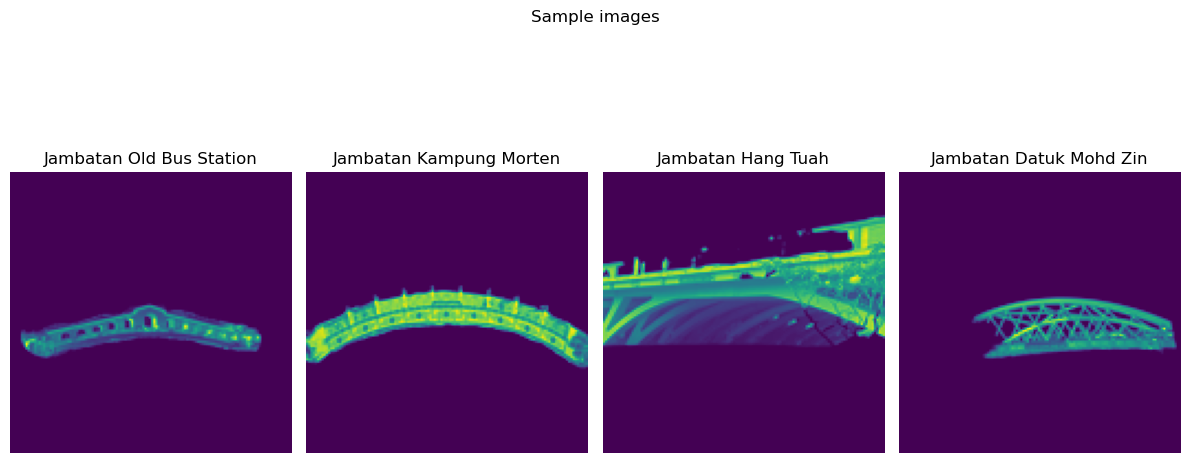

In [5]:
import matplotlib.pyplot as plt

# Reverse label_map to get label → bridge name
label_to_name = {v: k for k, v in label_map.items()}

fig = plt.figure(figsize=(12, 6))
fig.suptitle('Sample images')

displayed_images = {}
for i in range(len(x_train)):
    label = y_train[i]
    if label not in displayed_images:
        plt.subplot(1, len(label_to_name), len(displayed_images) + 1)
        plt.imshow(x_train[i].reshape(128, 128))
        plt.title(label_to_name[label])
        plt.axis('off')
        displayed_images[label] = True

    if len(displayed_images) == len(label_to_name):
        break

plt.tight_layout()
plt.show()

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Standardize
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

# PCA
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train_scaled)
x_valid_pca = pca.transform(x_valid_scaled)
x_test_pca = pca.transform(x_test_scaled)

# LDA
lda = LDA(n_components=3)
x_train_lda = lda.fit_transform(x_train, y_train)
x_valid_lda = lda.transform(x_valid)
x_test_lda = lda.transform(x_test)

# PCA + LDA
lda = LDA(n_components=3)
x_train_pca_lda = lda.fit_transform(x_train_pca, y_train)
x_valid_pca_lda = lda.transform(x_valid_pca)
x_test_pca_lda = lda.transform(x_test_pca)

In [11]:
# Add these imports to your existing code
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# 1. HYPERPARAMETER TUNING FOR KNN

def tune_knn_hyperparameters(X_train, y_train, X_valid, y_valid, feature_name=""):
    """
    Find the best k for KNN using validation set
    """
    print(f"\nTuning KNN for {feature_name} features...")
    
    # Test different k values
    k_range = range(1, 21)  # Test k from 1 to 20
    train_scores = []
    valid_scores = []
    
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Calculate training and validation accuracy
        train_acc = knn.score(X_train, y_train)
        valid_acc = knn.score(X_valid, y_valid)
        
        train_scores.append(train_acc)
        valid_scores.append(valid_acc)
    
    # Find best k
    best_k = k_range[valid_scores.index(max(valid_scores))]
    best_valid_score = max(valid_scores)
    
    print(f"Best k: {best_k}")
    print(f"Best validation accuracy: {best_valid_score:.4f}")
    
    return best_k, best_valid_score

# 2. HYPERPARAMETER TUNING FOR SVM

def tune_svm_hyperparameters(X_train, y_train, X_valid, y_valid, feature_name=""):
    """
    Find the best hyperparameters for SVM using GridSearchCV
    """
    print(f"\n🔧 Tuning SVM for {feature_name} features...")
    
    # Define parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1]
    }
    
    # Create SVM classifier
    svm = SVC(random_state=42)
    
    # Combine training and validation for cross-validation
    X_train_val = np.vstack([X_train, X_valid])
    y_train_val = np.hstack([y_train, y_valid])
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        svm, 
        param_grid, 
        cv=3,  # 3-fold cross-validation
        scoring='accuracy',
        n_jobs=-1,  # Use all available cores
        verbose=1
    )
    
    grid_search.fit(X_train_val, y_train_val)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_, grid_search.best_params_

# 3. COMPREHENSIVE EVALUATION FUNCTION

def evaluate_model_with_tuning(X_train, X_valid, X_test, y_train, y_valid, y_test, feature_name):
    """
    Complete evaluation with hyperparameter tuning
    """
    print(f"\n{'='*50}")
    print(f"EVALUATING {feature_name.upper()} FEATURES")
    print(f"{'='*50}")
    
    # Tune KNN
    best_k, _ = tune_knn_hyperparameters(X_train, y_train, X_valid, y_valid, feature_name)
    
    # Train best KNN model
    best_knn = KNeighborsClassifier(n_neighbors=best_k)
    best_knn.fit(X_train, y_train)
    
    # KNN predictions
    knn_train_pred = best_knn.predict(X_train)
    knn_valid_pred = best_knn.predict(X_valid)
    knn_test_pred = best_knn.predict(X_test)
    
    # Tune SVM
    best_svm, best_svm_params = tune_svm_hyperparameters(X_train, y_train, X_valid, y_valid, feature_name)
    
    # Train best SVM on training data only
    best_svm_final = SVC(**best_svm_params, random_state=42)
    best_svm_final.fit(X_train, y_train)
    
    # SVM predictions
    svm_train_pred = best_svm_final.predict(X_train)
    svm_valid_pred = best_svm_final.predict(X_valid)
    svm_test_pred = best_svm_final.predict(X_test)
    
    # Print results
    print(f"\nFINAL RESULTS for {feature_name}:")
    print("-" * 40)
    print("KNN Results:")
    print(f"  Best k: {best_k}")
    print(f"  Training Accuracy:   {accuracy_score(y_train, knn_train_pred):.4f}")
    print(f"  Validation Accuracy: {accuracy_score(y_valid, knn_valid_pred):.4f}")
    print(f"  Test Accuracy:       {accuracy_score(y_test, knn_test_pred):.4f}")
    
    print("\nSVM Results:")
    print(f"  Best params: {best_svm_params}")
    print(f"  Training Accuracy:   {accuracy_score(y_train, svm_train_pred):.4f}")
    print(f"  Validation Accuracy: {accuracy_score(y_valid, svm_valid_pred):.4f}")
    print(f"  Test Accuracy:       {accuracy_score(y_test, svm_test_pred):.4f}")
    
    return {
        'knn_model': best_knn,
        'svm_model': best_svm_final,
        'knn_results': {
            'train_acc': accuracy_score(y_train, knn_train_pred),
            'valid_acc': accuracy_score(y_valid, knn_valid_pred),
            'test_acc': accuracy_score(y_test, knn_test_pred)
        },
        'svm_results': {
            'train_acc': accuracy_score(y_train, svm_train_pred),
            'valid_acc': accuracy_score(y_valid, svm_valid_pred),
            'test_acc': accuracy_score(y_test, svm_test_pred)
        }
    }

# 4. REPLACE YOUR EXISTING MODEL TRAINING WITH THIS:

# Evaluate Original Features
results_original = evaluate_model_with_tuning(
    x_train_scaled, x_valid_scaled, x_test_scaled, y_train, y_valid, y_test, "Original"
)

# Evaluate PCA Features  
results_pca = evaluate_model_with_tuning(
    x_train_pca, x_valid_pca, x_test_pca, y_train, y_valid, y_test, "PCA"
)

# Evaluate LDA Features
results_lda = evaluate_model_with_tuning(
    x_train_lda, x_valid_lda, x_test_lda, y_train, y_valid, y_test, "LDA"
)

# Evaluate PCA+LDA Features
results_pca_lda = evaluate_model_with_tuning(
    x_train_pca_lda, x_valid_pca_lda, x_test_pca_lda, y_train, y_valid, y_test, "PCA+LDA"
)

# 5. SUMMARY COMPARISON
def compare_all_results(results_dict):
    """
    Compare all feature extraction methods
    """
    print("\n" + "="*80)
    print("FINAL COMPARISON OF ALL METHODS")
    print("="*80)
    
    methods = ['Original', 'PCA', 'LDA', 'PCA+LDA']
    results_list = [results_original, results_pca, results_lda, results_pca_lda]
    
    # Create comparison table
    print(f"{'Method':<12} {'KNN Test':<10} {'SVM Test':<10} {'Best Overall':<12}")
    print("-" * 50)
    
    best_knn_score = 0
    best_svm_score = 0
    best_knn_method = ""
    best_svm_method = ""
    
    for method, results in zip(methods, results_list):
        knn_test = results['knn_results']['test_acc']
        svm_test = results['svm_results']['test_acc']
        
        if knn_test > best_knn_score:
            best_knn_score = knn_test
            best_knn_method = method
            
        if svm_test > best_svm_score:
            best_svm_score = svm_test
            best_svm_method = method
        
        best_overall = max(knn_test, svm_test)
        best_model = "KNN" if knn_test > svm_test else "SVM"
        
        print(f"{method:<12} {knn_test:<10.4f} {svm_test:<10.4f} {best_model:<12}")
    
    print("\nBEST PREFORMANCE:")
    print(f"KNN: {best_knn_method} with {best_knn_score:.4f}")
    print(f"SVM: {best_svm_method} with {best_svm_score:.4f}")
    print(f"Overall Best: {'KNN' if best_knn_score > best_svm_score else 'SVM'} with {max(best_knn_score, best_svm_score):.4f}")

# Run the comparison
compare_all_results({
    'Original': results_original,
    'PCA': results_pca, 
    'LDA': results_lda,
    'PCA+LDA': results_pca_lda
})


EVALUATING ORIGINAL FEATURES

Tuning KNN for Original features...
Best k: 13
Best validation accuracy: 0.7917

🔧 Tuning SVM for Original features...
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score: 0.7778

FINAL RESULTS for Original:
----------------------------------------
KNN Results:
  Best k: 13
  Training Accuracy:   0.7812
  Validation Accuracy: 0.7917
  Test Accuracy:       0.7083

SVM Results:
  Best params: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
  Training Accuracy:   1.0000
  Validation Accuracy: 0.8333
  Test Accuracy:       0.7500

EVALUATING PCA FEATURES

Tuning KNN for PCA features...
Best k: 1
Best validation accuracy: 0.7917

🔧 Tuning SVM for PCA features...
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.7593

FINAL RESULTS for PCA:
----------------------

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_classification(y_true, y_pred, dataset_name):
    print(f"\nClassification Report — {dataset_name}")
    target_names = [str(i) for i in sorted(set(y_true))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix — {dataset_name}")
    plt.show()

In [15]:
# Train KNN with original features
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(x_train_scaled, y_train)

# Predict on training, validation, and test sets
y_train_pred_knn = knn.predict(x_train_scaled)
y_valid_pred_knn = knn.predict(x_valid_scaled)
y_test_pred_knn = knn.predict(x_test_scaled)

# Print the accuracy
print("KNN Original Features:")
print(f"Training Accuracy:   {accuracy_score(y_train, y_train_pred_knn):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_valid, y_valid_pred_knn):.4f}")
print(f"Testing Accuracy:    {accuracy_score(y_test,  y_test_pred_knn):.4f}")

KNN Original Features:
Training Accuracy:   0.7812
Validation Accuracy: 0.7917
Testing Accuracy:    0.7083



Classification Report — KNN - Train Set
              precision    recall  f1-score   support

           0       0.80      0.94      0.87        48
           1       0.77      0.56      0.65        48
           2       0.75      0.85      0.80        48
           3       0.80      0.77      0.79        48

    accuracy                           0.78       192
   macro avg       0.78      0.78      0.77       192
weighted avg       0.78      0.78      0.77       192



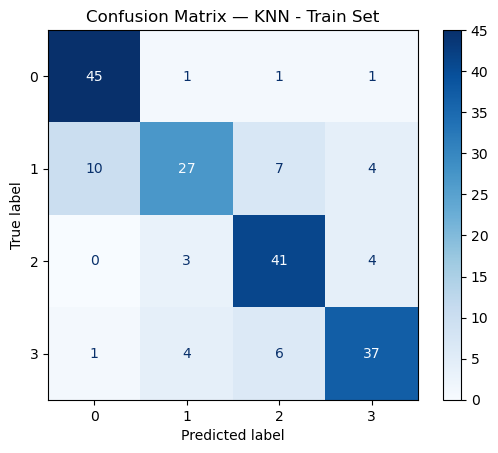

In [21]:
evaluate_classification(y_train, y_train_pred_knn, "KNN - Train Set")


Classification Report — KNN - Validation Set
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.71      0.83      0.77         6
           2       0.75      1.00      0.86         6
           3       0.75      0.50      0.60         6

    accuracy                           0.79        24
   macro avg       0.80      0.79      0.78        24
weighted avg       0.80      0.79      0.78        24



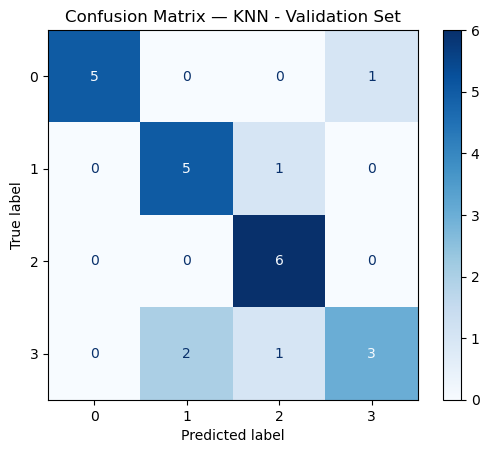

In [23]:
evaluate_classification(y_valid, y_valid_pred_knn, "KNN - Validation Set")


Classification Report — KNN - Test Set
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       1.00      0.67      0.80         6
           2       0.67      0.67      0.67         6
           3       0.60      0.50      0.55         6

    accuracy                           0.71        24
   macro avg       0.73      0.71      0.70        24
weighted avg       0.73      0.71      0.70        24



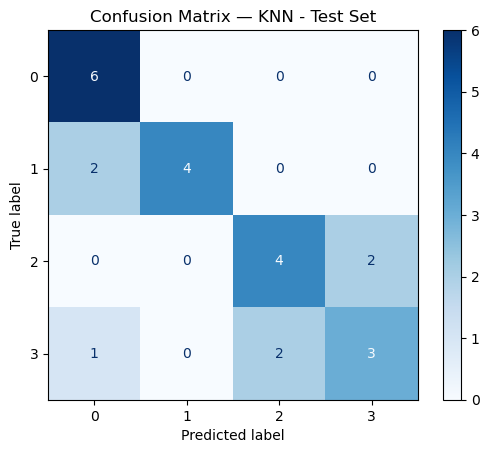

In [25]:
evaluate_classification(y_test,  y_test_pred_knn,  "KNN - Test Set")

In [27]:
# Train KNN with PCA features
knn_pca = KNeighborsClassifier(n_neighbors=1)
knn_pca.fit(x_train_pca, y_train)

# Predict on training, validation, and test sets
y_train_pred_knn_pca = knn_pca.predict(x_train_pca)
y_valid_pred_knn_pca = knn_pca.predict(x_valid_pca)
y_test_pred_knn_pca = knn_pca.predict(x_test_pca)

# Print the accuracy
print("KNN on PCA Features:")
print(f"Training Accuracy:   {accuracy_score(y_train, y_train_pred_knn_pca):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_valid, y_valid_pred_knn_pca):.4f}")
print(f"Testing Accuracy:    {accuracy_score(y_test,  y_test_pred_knn_pca):.4f}")

KNN on PCA Features:
Training Accuracy:   1.0000
Validation Accuracy: 0.7917
Testing Accuracy:    0.9167



Classification Report — KNN PCA - Train Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        48
           2       1.00      1.00      1.00        48
           3       1.00      1.00      1.00        48

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192



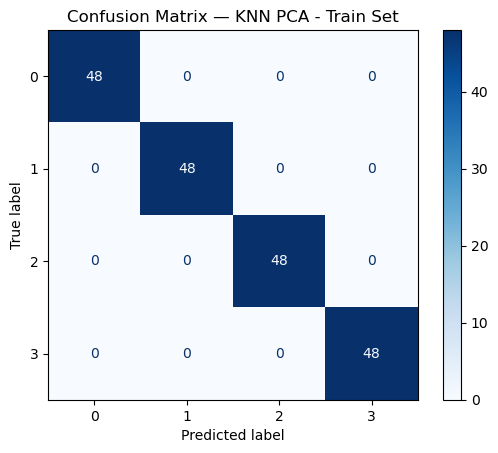

In [29]:
evaluate_classification(y_train, y_train_pred_knn_pca, "KNN PCA - Train Set")


Classification Report — KNN PCA - Validation Set
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       1.00      0.67      0.80         6
           2       1.00      0.83      0.91         6
           3       0.62      0.83      0.71         6

    accuracy                           0.79        24
   macro avg       0.83      0.79      0.80        24
weighted avg       0.83      0.79      0.80        24



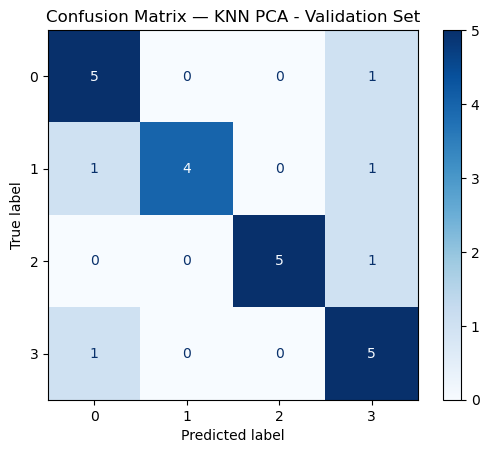

In [31]:
evaluate_classification(y_valid, y_valid_pred_knn_pca, "KNN PCA - Validation Set")


Classification Report — KNN PCA - Test Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       0.83      0.83      0.83         6
           3       0.83      0.83      0.83         6

    accuracy                           0.92        24
   macro avg       0.92      0.92      0.92        24
weighted avg       0.92      0.92      0.92        24



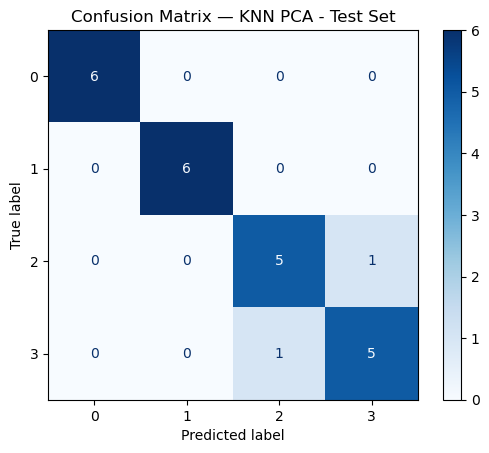

In [33]:
evaluate_classification(y_test,  y_test_pred_knn_pca,  "KNN PCA - Test Set")

In [35]:
# Train KNN with LDA features
knn_lda = KNeighborsClassifier(n_neighbors=1)
knn_lda.fit(x_train_lda, y_train)

# Predict on training, validation, and test sets
y_train_pred_knn_lda = knn_lda.predict(x_train_lda)
y_valid_pred_knn_lda = knn_lda.predict(x_valid_lda)
y_test_pred_knn_lda  = knn_lda.predict(x_test_lda)

# Print the accuracy
print("KNN on LDA Features:")
print(f"Training Accuracy:   {accuracy_score(y_train, y_train_pred_knn_lda):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_valid, y_valid_pred_knn_lda):.4f}")
print(f"Testing Accuracy:    {accuracy_score(y_test,  y_test_pred_knn_lda):.4f}")

KNN on LDA Features:
Training Accuracy:   1.0000
Validation Accuracy: 0.6250
Testing Accuracy:    0.5417



Classification Report — KNN LDA - Train Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        48
           2       1.00      1.00      1.00        48
           3       1.00      1.00      1.00        48

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192



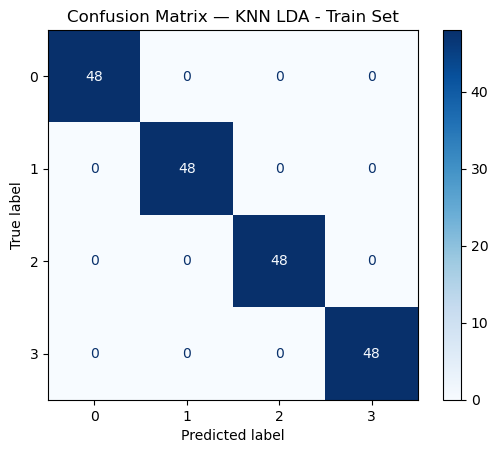

In [37]:
evaluate_classification(y_train, y_train_pred_knn_lda, "KNN LDA - Train Set")


Classification Report — KNN LDA - Validation Set
              precision    recall  f1-score   support

           0       0.40      0.33      0.36         6
           1       0.80      0.67      0.73         6
           2       0.67      1.00      0.80         6
           3       0.60      0.50      0.55         6

    accuracy                           0.62        24
   macro avg       0.62      0.62      0.61        24
weighted avg       0.62      0.62      0.61        24



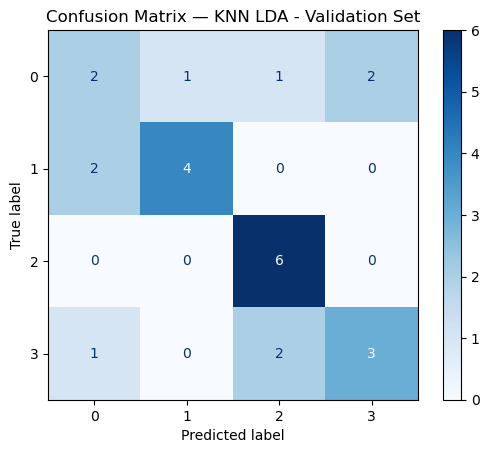

In [39]:
evaluate_classification(y_valid, y_valid_pred_knn_lda, "KNN LDA - Validation Set")


Classification Report — KNN LDA - Test Set
              precision    recall  f1-score   support

           0       0.33      0.17      0.22         6
           1       1.00      0.50      0.67         6
           2       0.44      0.67      0.53         6
           3       0.56      0.83      0.67         6

    accuracy                           0.54        24
   macro avg       0.58      0.54      0.52        24
weighted avg       0.58      0.54      0.52        24



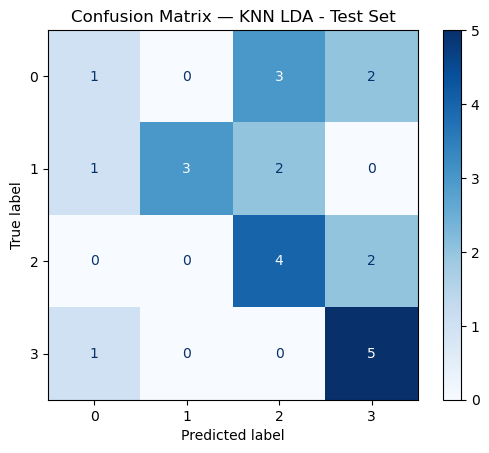

In [41]:
evaluate_classification(y_test, y_test_pred_knn_lda,  "KNN LDA - Test Set")

In [43]:
# Train KNN with PCA + LDA features
knn_pca_lda = KNeighborsClassifier(n_neighbors=6)
knn_pca_lda.fit(x_train_pca_lda, y_train)

# Predict on training, validation, and test sets
y_train_pred_knn_pca_lda = knn_pca_lda.predict(x_train_pca_lda)
y_valid_pred_knn_pca_lda = knn_pca_lda.predict(x_valid_pca_lda)
y_test_pred_knn_pca_lda  = knn_pca_lda.predict(x_test_pca_lda)

# Print the accuracy
print("KNN on PCA + LDA Features:")
print(f"Training Accuracy:   {accuracy_score(y_train, y_train_pred_knn_pca_lda):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_valid, y_valid_pred_knn_pca_lda):.4f}")
print(f"Testing Accuracy:    {accuracy_score(y_test,  y_test_pred_knn_pca_lda):.4f}")

KNN on PCA + LDA Features:
Training Accuracy:   0.8646
Validation Accuracy: 0.6667
Testing Accuracy:    0.7083



Classification Report — KNN PCA + LDA - Train Set
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        48
           1       0.86      0.79      0.83        48
           2       0.81      0.90      0.85        48
           3       0.95      0.85      0.90        48

    accuracy                           0.86       192
   macro avg       0.87      0.86      0.86       192
weighted avg       0.87      0.86      0.86       192



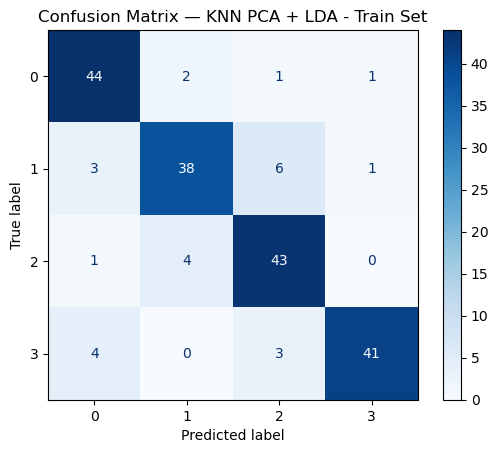

In [45]:
evaluate_classification(y_train, y_train_pred_knn_pca_lda, "KNN PCA + LDA - Train Set")


Classification Report — KNN PCA + LDA - Validation Set
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.60      0.50      0.55         6
           2       0.75      1.00      0.86         6
           3       1.00      0.50      0.67         6

    accuracy                           0.67        24
   macro avg       0.71      0.67      0.66        24
weighted avg       0.71      0.67      0.66        24



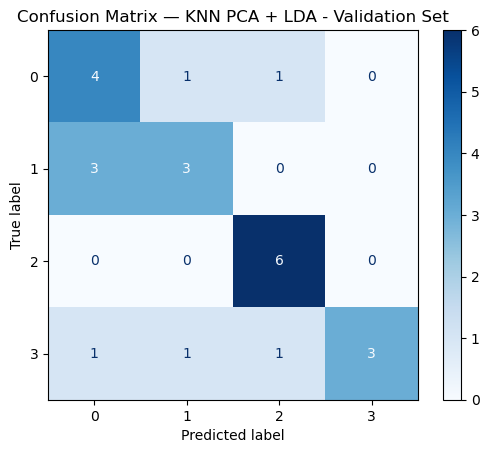

In [47]:
evaluate_classification(y_valid, y_valid_pred_knn_pca_lda, "KNN PCA + LDA - Validation Set")


Classification Report — KNN PCA + LDA - Test Set
              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.80      0.67      0.73         6
           2       0.71      0.83      0.77         6
           3       0.80      0.67      0.73         6

    accuracy                           0.71        24
   macro avg       0.72      0.71      0.71        24
weighted avg       0.72      0.71      0.71        24



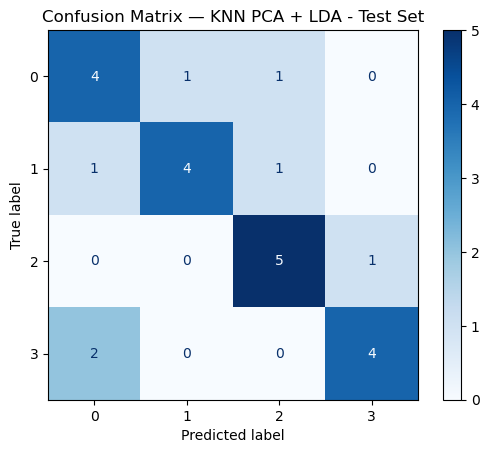

In [49]:
evaluate_classification(y_test, y_test_pred_knn_pca_lda,  "KNN PCA + LDA - Test Set")

In [51]:
# Train SVM on original features
svm = SVC(kernel='rbf', C=100, gamma='auto', random_state=42)
svm.fit(x_train_scaled, y_train)

# Predict on training, validation, and test sets
y_train_pred_svm = svm.predict(x_train_scaled)
y_valid_pred_svm = svm.predict(x_valid_scaled)
y_test_pred_svm  = svm.predict(x_test_scaled)

# Print the accuracy
print("SVM on original Features:")
print(f"Training Accuracy:   {accuracy_score(y_train, y_train_pred_svm):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_valid, y_valid_pred_svm):.4f}")
print(f"Testing Accuracy:    {accuracy_score(y_test,  y_test_pred_svm):.4f}")

SVM on original Features:
Training Accuracy:   1.0000
Validation Accuracy: 0.8333
Testing Accuracy:    0.7500



Classification Report — SVM - Train Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        48
           2       1.00      1.00      1.00        48
           3       1.00      1.00      1.00        48

    accuracy                           1.00       192
   macro avg       1.00      1.00      1.00       192
weighted avg       1.00      1.00      1.00       192



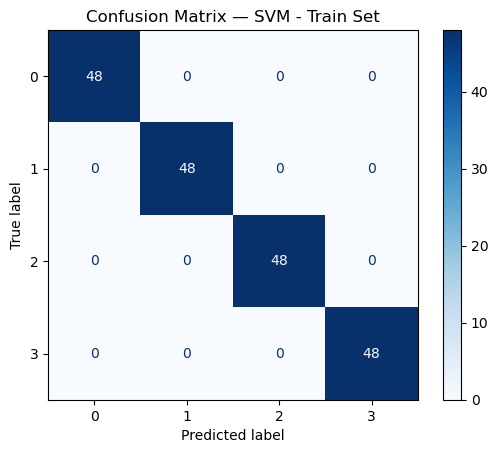

In [53]:
evaluate_classification(y_train, y_train_pred_svm, "SVM - Train Set")


Classification Report — SVM - Validation Set
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       1.00      0.83      0.91         6
           2       0.86      1.00      0.92         6
           3       0.80      0.67      0.73         6

    accuracy                           0.83        24
   macro avg       0.84      0.83      0.83        24
weighted avg       0.84      0.83      0.83        24



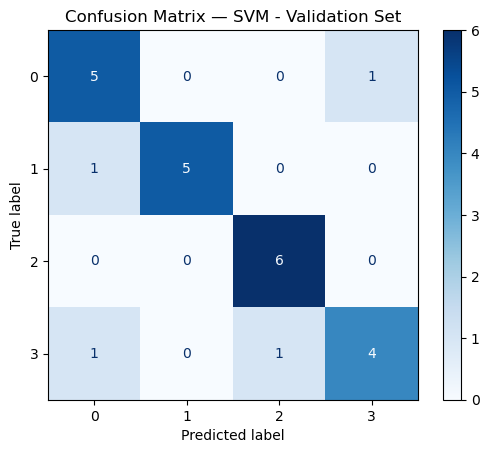

In [55]:
evaluate_classification(y_valid, y_valid_pred_svm, "SVM - Validation Set")


Classification Report — SVM - Test Set
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.83      0.83      0.83         6
           2       0.62      0.83      0.71         6
           3       0.67      0.33      0.44         6

    accuracy                           0.75        24
   macro avg       0.75      0.75      0.73        24
weighted avg       0.75      0.75      0.73        24



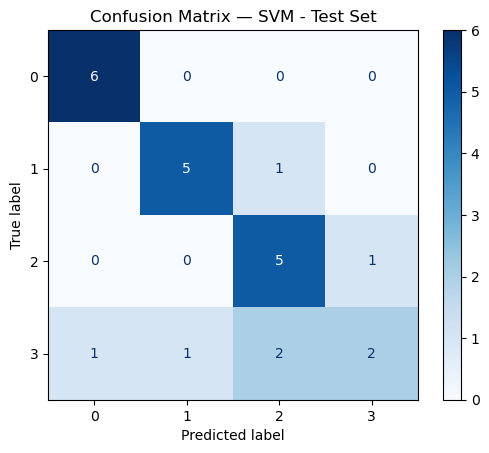

In [57]:
evaluate_classification(y_test, y_test_pred_svm,  "SVM - Test Set")

In [59]:
# Train SVM on PCA features
svm_pca = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm_pca.fit(x_train_pca, y_train)

# Predict on training, validation, and test sets
y_train_pred_svm_pca = svm_pca.predict(x_train_pca)
y_valid_pred_svm_pca = svm_pca.predict(x_valid_pca)
y_test_pred_svm_pca  = svm_pca.predict(x_test_pca)

# Print the accuracy
print("SVM on PCA Features:")
print(f"Training Accuracy:   {accuracy_score(y_train, y_train_pred_svm_pca):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_valid, y_valid_pred_svm_pca):.4f}")
print(f"Testing Accuracy:    {accuracy_score(y_test,  y_test_pred_svm_pca):.4f}")

SVM on PCA Features:
Training Accuracy:   0.9792
Validation Accuracy: 0.8333
Testing Accuracy:    0.8750



Classification Report — SVM PCA - Train Set
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        48
           1       0.94      1.00      0.97        48
           2       0.98      1.00      0.99        48
           3       1.00      0.96      0.98        48

    accuracy                           0.98       192
   macro avg       0.98      0.98      0.98       192
weighted avg       0.98      0.98      0.98       192



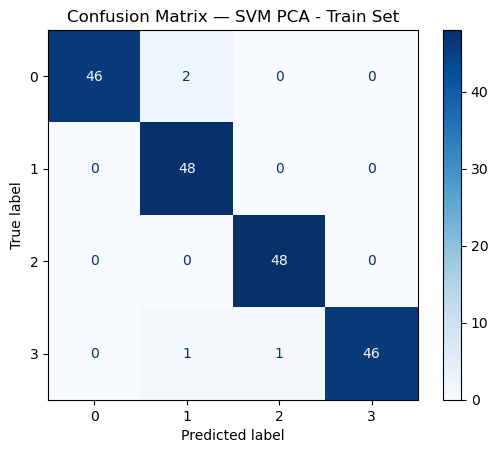

In [61]:
evaluate_classification(y_train, y_train_pred_svm_pca, "SVM PCA - Train Set")


Classification Report — SVM PCA - Validation Set
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       1.00      0.83      0.91         6
           2       0.86      1.00      0.92         6
           3       0.80      0.67      0.73         6

    accuracy                           0.83        24
   macro avg       0.84      0.83      0.83        24
weighted avg       0.84      0.83      0.83        24



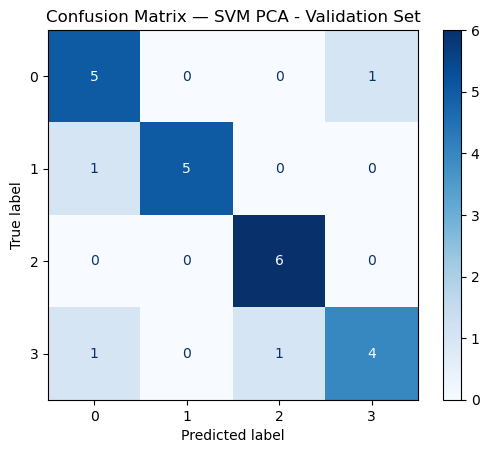

In [63]:
evaluate_classification(y_valid, y_valid_pred_svm_pca, "SVM PCA - Validation Set")


Classification Report — SVM PCA - Test Set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6
           2       0.71      0.83      0.77         6
           3       0.80      0.67      0.73         6

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.87        24



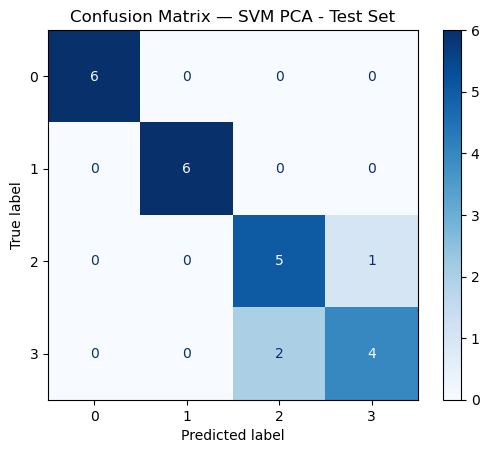

In [65]:
evaluate_classification(y_test, y_test_pred_svm_pca,  "SVM PCA - Test Set")

In [67]:
# Train SVM on LDA features
svm_lda = SVC(kernel='rbf', C=0.1, gamma=0.1, random_state=42)
svm_lda.fit(x_train_lda, y_train)

# Predict on training, validation, and test sets
y_train_pred_svm_lda = svm_lda.predict(x_train_lda)
y_valid_pred_svm_lda = svm_lda.predict(x_valid_lda)
y_test_pred_svm_lda  = svm_lda.predict(x_test_lda)

# Print the accuracy
print("SVM on LDA Features:")
print(f"Training Accuracy:   {accuracy_score(y_train, y_train_pred_svm_lda):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_valid, y_valid_pred_svm_lda):.4f}")
print(f"Testing Accuracy:    {accuracy_score(y_test,  y_test_pred_svm_lda):.4f}")

SVM on LDA Features:
Training Accuracy:   0.9427
Validation Accuracy: 0.5833
Testing Accuracy:    0.5417



Classification Report — SVM LDA - Train Set
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        48
           1       0.92      0.94      0.93        48
           2       0.92      0.96      0.94        48
           3       1.00      0.94      0.97        48

    accuracy                           0.94       192
   macro avg       0.94      0.94      0.94       192
weighted avg       0.94      0.94      0.94       192



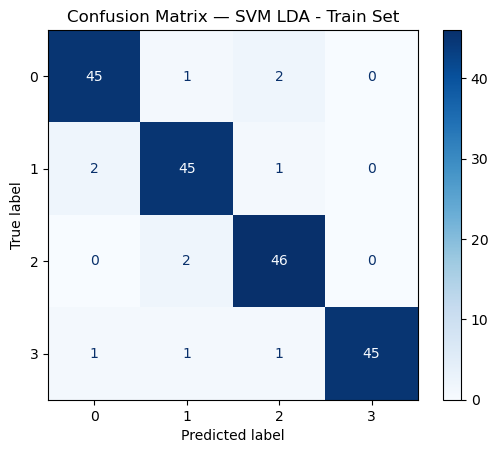

In [69]:
evaluate_classification(y_train, y_train_pred_svm_lda, "SVM LDA - Train Set")


Classification Report — SVM LDA - Validation Set
              precision    recall  f1-score   support

           0       0.40      0.33      0.36         6
           1       0.43      0.50      0.46         6
           2       1.00      1.00      1.00         6
           3       0.50      0.50      0.50         6

    accuracy                           0.58        24
   macro avg       0.58      0.58      0.58        24
weighted avg       0.58      0.58      0.58        24



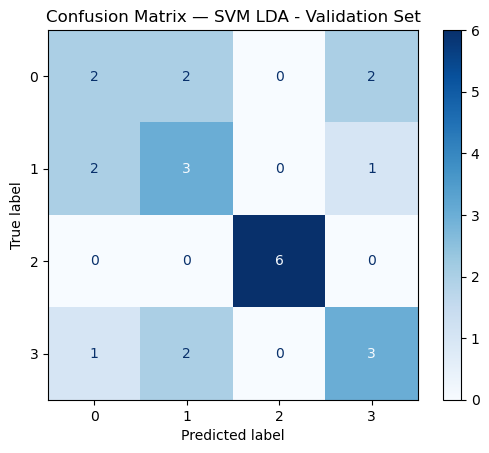

In [71]:
evaluate_classification(y_valid, y_valid_pred_svm_lda, "SVM LDA - Validation Set")


Classification Report — SVM LDA - Test Set
              precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
           1       0.75      0.50      0.60         6
           2       0.56      0.83      0.67         6
           3       0.57      0.67      0.62         6

    accuracy                           0.54        24
   macro avg       0.53      0.54      0.52        24
weighted avg       0.53      0.54      0.52        24



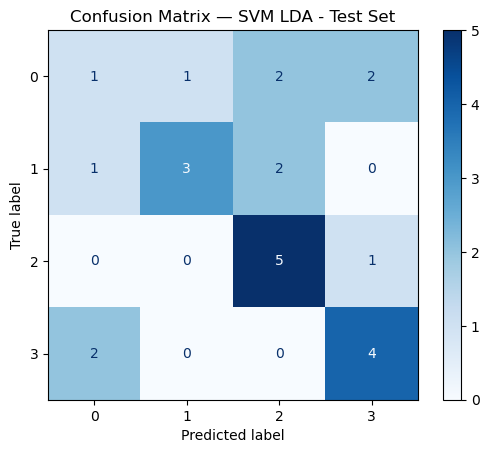

In [73]:
evaluate_classification(y_test, y_test_pred_svm_lda,  "SVM LDA - Test Set")

In [75]:
# Train on PCA+LDA features
svm_pca_lda = SVC(kernel='rbf', C=10, gamma=0.01, random_state=42)
svm_pca_lda.fit(x_train_pca_lda, y_train)

# Predict on training, validation, and test sets
y_train_pred_svm_pca_lda = svm_pca_lda.predict(x_train_pca_lda)
y_valid_pred_svm_pca_lda = svm_pca_lda.predict(x_valid_pca_lda)
y_test_pred_svm_pca_lda  = svm_pca_lda.predict(x_test_pca_lda)

# Print the accuracy
print("SVM on PCA + LDA Features:")
print(f"Training Accuracy:   {accuracy_score(y_train, y_train_pred_svm_pca_lda):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_valid, y_valid_pred_svm_pca_lda):.4f}")
print(f"Testing Accuracy:    {accuracy_score(y_test,  y_test_pred_svm_pca_lda):.4f}")

SVM on PCA + LDA Features:
Training Accuracy:   0.8906
Validation Accuracy: 0.5833
Testing Accuracy:    0.7083



Classification Report — SVM PCA + LDA - Train Set
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        48
           1       0.79      0.88      0.83        48
           2       0.86      0.90      0.88        48
           3       0.94      0.94      0.94        48

    accuracy                           0.89       192
   macro avg       0.90      0.89      0.89       192
weighted avg       0.90      0.89      0.89       192



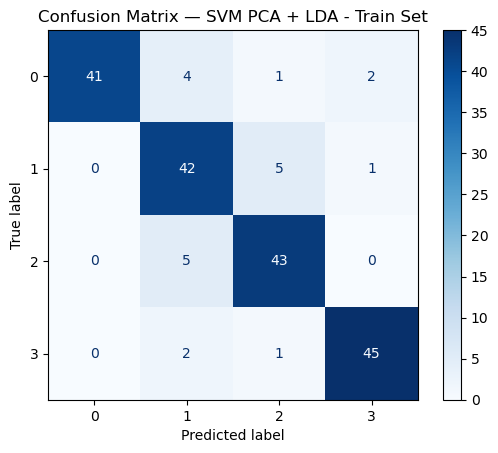

In [77]:
evaluate_classification(y_train, y_train_pred_svm_pca_lda, "SVM PCA + LDA - Train Set")


Classification Report — SVM PCA + LDA - Validation Set
              precision    recall  f1-score   support

           0       0.33      0.17      0.22         6
           1       0.57      0.67      0.62         6
           2       0.67      1.00      0.80         6
           3       0.60      0.50      0.55         6

    accuracy                           0.58        24
   macro avg       0.54      0.58      0.55        24
weighted avg       0.54      0.58      0.55        24



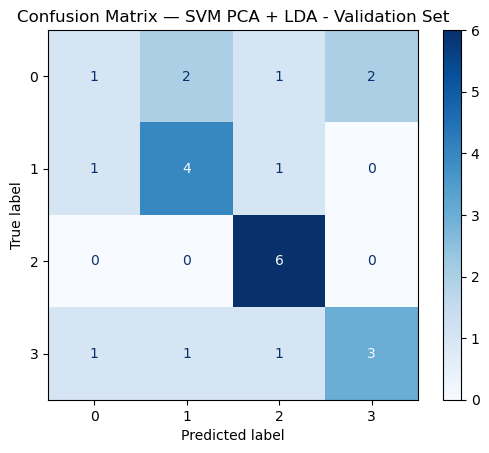

In [79]:
evaluate_classification(y_valid, y_valid_pred_svm_pca_lda, "SVM PCA + LDA - Validation Set")


Classification Report — SVM PCA + LDA - Test Set
              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.57      0.67      0.62         6
           2       0.71      0.83      0.77         6
           3       0.83      0.83      0.83         6

    accuracy                           0.71        24
   macro avg       0.72      0.71      0.70        24
weighted avg       0.72      0.71      0.70        24



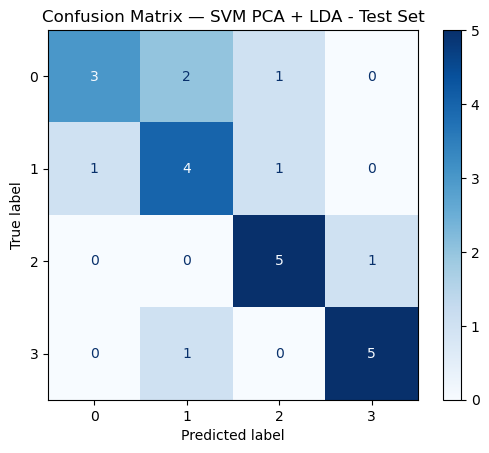

In [81]:
evaluate_classification(y_test, y_test_pred_svm_pca_lda,  "SVM PCA + LDA - Test Set")

In [ ]:
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
from PIL import Image, ImageTk
import numpy as np
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import os
import threading
import time

class BridgeClassifierGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Bridge Classification System")
        self.root.geometry("1200x800")
        self.root.configure(bg='#f0f0f0')
        
        # Bridge names mapping
        self.bridge_names = {
            0: "Jambatan Datuk Mohd Zin",
            1: "Jambatan Hang Tuah", 
            2: "Jambatan Kampung Morten",
            3: "Jambatan Old Bus Station"
        }
        
        # Model storage
        self.models = {}
        self.scaler = None  # Added StandardScaler
        self.pca = None
        self.lda = None
        self.pca_lda = None
        self.is_models_loaded = False
        self.selected_image_path = None
        self.processed_image = None
        
        self.setup_ui()
        self.load_models()
    
    def setup_ui(self):
        # Main title
        title_frame = tk.Frame(self.root, bg='#2c3e50', height=80)
        title_frame.pack(fill='x', pady=(0, 20))
        title_frame.pack_propagate(False)
        
        title_label = tk.Label(title_frame, text="Bridge Classification System", 
                              font=('Arial', 24, 'bold'), fg='white', bg='#2c3e50')
        title_label.pack(expand=True)
        
        # Main content frame
        main_frame = tk.Frame(self.root, bg='#f0f0f0')
        main_frame.pack(fill='both', expand=True, padx=20, pady=10)
        
        # Left panel - Image upload and display
        left_frame = tk.LabelFrame(main_frame, text="Image Upload & Preview", 
                                  font=('Arial', 12, 'bold'), bg='#f0f0f0', padx=10, pady=10)
        left_frame.pack(side='left', fill='both', expand=True, padx=(0, 10))
        
        # Upload button
        self.upload_btn = tk.Button(left_frame, text="Select Bridge Image", 
                                   command=self.upload_image, font=('Arial', 12, 'bold'),
                                   bg='#3498db', fg='white', padx=20, pady=10,
                                   cursor='hand2')
        self.upload_btn.pack(pady=10)
        
        # Image display
        self.image_frame = tk.Frame(left_frame, bg='white', relief='sunken', bd=2)
        self.image_frame.pack(fill='both', expand=True, pady=10)
        
        self.image_label = tk.Label(self.image_frame, text="No image selected\n\nClick 'Select Bridge Image' to upload",
                                   font=('Arial', 12), bg='white', fg='gray')
        self.image_label.pack(expand=True)
        
        # Right panel - Classification results
        right_frame = tk.LabelFrame(main_frame, text="Classification Results", 
                                   font=('Arial', 12, 'bold'), bg='#f0f0f0', padx=10, pady=10)
        right_frame.pack(side='right', fill='both', expand=True)
        
        # Model selection
        model_frame = tk.Frame(right_frame, bg='#f0f0f0')
        model_frame.pack(fill='x', pady=(0, 20))
        
        tk.Label(model_frame, text="Select Classification Model:", 
                font=('Arial', 11, 'bold'), bg='#f0f0f0').pack(anchor='w')
        
        self.model_var = tk.StringVar(value="KNN (PCA) - Preferred")
        models = ["KNN (PCA) - Preferred", "KNN (Original)", "KNN (LDA)", "KNN (PCA+LDA)", 
          "SVM RBF (Original)", "SVM RBF (PCA)", "SVM RBF (LDA)", "SVM RBF (PCA+LDA)"]
        
        self.model_combo = ttk.Combobox(model_frame, textvariable=self.model_var, 
                                       values=models, state='readonly', font=('Arial', 10))
        self.model_combo.pack(fill='x', pady=5)
        
        # Classify button
        self.classify_btn = tk.Button(right_frame, text="Classify Bridge", 
                                     command=self.classify_image, font=('Arial', 12, 'bold'),
                                     bg='#27ae60', fg='white', padx=20, pady=10,
                                     cursor='hand2', state='disabled')
        self.classify_btn.pack(pady=10)
        
        # Progress bar
        self.progress = ttk.Progressbar(right_frame, mode='indeterminate')
        self.progress.pack(fill='x', pady=5)
        
        # Results display
        results_frame = tk.Frame(right_frame, bg='#f0f0f0')
        results_frame.pack(fill='both', expand=True, pady=10)
        
        # Prediction result
        self.result_frame = tk.Frame(results_frame, bg='white', relief='raised', bd=2)
        self.result_frame.pack(fill='x', pady=5)
        
        self.result_label = tk.Label(self.result_frame, text="Prediction will appear here", 
                                    font=('Arial', 14, 'bold'), bg='white', pady=20)
        self.result_label.pack()
        
        # Confidence/Info display
        self.info_frame = tk.Frame(results_frame, bg='#ecf0f1', relief='groove', bd=1)
        self.info_frame.pack(fill='both', expand=True, pady=5)
        
        self.info_label = tk.Label(self.info_frame, text="Additional information will appear here",
                                  font=('Arial', 10), bg='#ecf0f1', justify='left', anchor='nw')
        self.info_label.pack(fill='both', expand=True, padx=10, pady=10)
        
        # Status bar
        self.status_var = tk.StringVar(value="Ready - Please load training data first")
        status_bar = tk.Label(self.root, textvariable=self.status_var, 
                             relief='sunken', anchor='w', font=('Arial', 9))
        status_bar.pack(side='bottom', fill='x')
    
    def load_models(self):
        """Load and train all models from the dataset"""
        def load_in_background():
            try:
                self.status_var.set("Loading dataset and training models...")
                self.root.update()
                
                # Load dataset (you'll need to adjust the path)
                dataset_path = 'C:/Users/User/Desktop/TPR 6223/project/preprocessed_dataset/bridge_dataset.h5'
                
                if not os.path.exists(dataset_path):
                    messagebox.showerror("Error", f"Dataset file not found at: {dataset_path}\n\nPlease ensure the dataset file exists.")
                    self.status_var.set("Error: Dataset not found")
                    return
                
                with h5py.File(dataset_path, 'r') as hf:
                    X = hf['images'][:]
                    y = hf['labels'][:]
                
                # Split data
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
                
                # Store for later use
                self.X_train = X_train
                self.y_train = y_train
                
                # STANDARDIZATION - Added StandardScaler
                self.status_var.set("Standardizing data...")
                self.root.update()
                self.scaler = StandardScaler()
                X_train_scaled = self.scaler.fit_transform(X_train)
                
                # Train PCA on SCALED data
                self.status_var.set("Training PCA...")
                self.root.update()
                self.pca = PCA(n_components=0.95)
                X_train_pca = self.pca.fit_transform(X_train_scaled)
                
                # Train LDA on SCALED data
                self.status_var.set("Training LDA...")
                self.root.update()
                self.lda = LDA(n_components=3)
                X_train_lda = self.lda.fit_transform(X_train_scaled, y_train)
                
                # Train PCA+LDA on SCALED data
                self.status_var.set("Training PCA+LDA...")
                self.root.update()
                self.pca_lda = LDA(n_components=3)
                X_train_pca_lda = self.pca_lda.fit_transform(X_train_pca, y_train)
                
                # Train all models
                self.status_var.set("Training classification models...")
                self.root.update()
                
                # KNN models
                self.models['KNN (Original)'] = KNeighborsClassifier(n_neighbors=13)
                self.models['KNN (Original)'].fit(X_train_scaled, y_train)
                
                self.models['KNN (PCA) - Preferred'] = KNeighborsClassifier(n_neighbors=1)
                self.models['KNN (PCA) - Preferred'].fit(X_train_pca, y_train)
                
                self.models['KNN (LDA)'] = KNeighborsClassifier(n_neighbors=1)
                self.models['KNN (LDA)'].fit(X_train_lda, y_train)
                
                self.models['KNN (PCA+LDA)'] = KNeighborsClassifier(n_neighbors=6)
                self.models['KNN (PCA+LDA)'].fit(X_train_pca_lda, y_train)
                
                # SVM models
                self.models['SVM RBF (Original)'] = SVC(kernel='rbf', C=100, gamma='auto', random_state=42)
                self.models['SVM RBF (Original)'].fit(X_train_scaled, y_train)
                
                self.models['SVM RBF (PCA)'] = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
                self.models['SVM RBF (PCA)'].fit(X_train_pca, y_train)
                
                self.models['SVM RBF (LDA)'] = SVC(kernel='rbf', C=0.1, gamma=0.1, random_state=42)
                self.models['SVM RBF (LDA)'].fit(X_train_lda, y_train)
                
                self.models['SVM RBF (PCA+LDA)'] = SVC(kernel='rbf', C=10, gamma=0.01, random_state=42)
                self.models['SVM RBF (PCA+LDA)'].fit(X_train_pca_lda, y_train)
                
                self.is_models_loaded = True
                self.status_var.set("Models loaded successfully! Ready for classification.")
                
            except Exception as e:
                messagebox.showerror("Error", f"Failed to load models: {str(e)}")
                self.status_var.set("Error loading models")
        
        # Run in background thread
        thread = threading.Thread(target=load_in_background)
        thread.daemon = True
        thread.start()
    
    def upload_image(self):
        """Handle image upload"""
        file_path = filedialog.askopenfilename(
            title="Select Bridge Image",
            filetypes=[
                ("Image files", "*.jpg *.jpeg *.png *.bmp *.tiff *.gif"),
                ("JPEG files", "*.jpg *.jpeg"),
                ("PNG files", "*.png"),
                ("All files", "*.*")
            ]
        )
        
        if file_path:
            try:
                self.selected_image_path = file_path
                
                # Load and display image
                image = Image.open(file_path)
                
                # Resize for display while maintaining aspect ratio
                display_size = (400, 300)
                image.thumbnail(display_size, Image.Resampling.LANCZOS)
                
                # Convert to PhotoImage for tkinter
                photo = ImageTk.PhotoImage(image)
                
                # Update image label
                self.image_label.configure(image=photo, text="")
                self.image_label.image = photo  # Keep a reference
                
                # Process image for classification
                self.preprocess_image(file_path)
                
                # Enable classify button if models are loaded
                if self.is_models_loaded:
                    self.classify_btn.configure(state='normal')
                
                self.status_var.set(f"Image loaded: {os.path.basename(file_path)}")
                
            except Exception as e:
                messagebox.showerror("Error", f"Failed to load image: {str(e)}")
    
    def preprocess_image(self, image_path):
        """Preprocess image for classification (same as training)"""
        try:
            # Load image, convert to grayscale, resize to 128x128
            img = Image.open(image_path).convert('L')
            img = img.resize((128, 128))
            
            # Convert to numpy array and normalize
            img_array = np.asarray(img, dtype=np.float32) / 255.0
            
            # Flatten for classification
            self.processed_image = img_array.reshape(1, -1)  # Shape: (1, 16384)
            
        except Exception as e:
            messagebox.showerror("Error", f"Failed to preprocess image: {str(e)}")
    
    def classify_image(self):
        """Classify the uploaded image"""
        if not self.is_models_loaded:
            messagebox.showwarning("Warning", "Models are still loading. Please wait.")
            return
        
        if self.processed_image is None:
            messagebox.showwarning("Warning", "Please upload an image first.")
            return
        
        try:
            # Start progress bar
            self.progress.start()
            self.classify_btn.configure(state='disabled')
            
            # Get selected model
            model_name = self.model_var.get()
            model = self.models[model_name]
            
            # Apply standardization FIRST (same as training)
            image_scaled = self.scaler.transform(self.processed_image)
            
            # Apply appropriate feature transformation
            if 'PCA+LDA' in model_name:
                # Apply PCA then LDA on SCALED data
                image_features = self.pca.transform(image_scaled)
                image_features = self.pca_lda.transform(image_features)
            elif 'PCA' in model_name:
                # Apply PCA only on SCALED data
                image_features = self.pca.transform(image_scaled)
            elif 'LDA' in model_name:
                # Apply LDA only on SCALED data
                image_features = self.lda.transform(image_scaled)
            else:
                # Use scaled features (not raw)
                image_features = image_scaled
            
            # Make prediction
            prediction = model.predict(image_features)[0]
            bridge_name = self.bridge_names[prediction]
            
            # Get prediction probabilities if available
            info_text = f"Model Used: {model_name}\n"
            info_text += f"Image Shape: 128x128 grayscale\n"
            info_text += f"Preprocessing: Normalized + Standardized\n"
            info_text += f"Feature Dimensions: {image_features.shape[1]}\n"
            
            if hasattr(model, 'predict_proba'):
                try:
                    probabilities = model.predict_proba(image_features)[0]
                    info_text += "\nPrediction Probabilities:\n"
                    for i, prob in enumerate(probabilities):
                        info_text += f"  {self.bridge_names[i]}: {prob:.3f}\n"
                except:
                    pass
            
            # Update UI
            self.result_label.configure(text=f"{bridge_name}", 
                                       bg='#d5f4e6', fg='#27ae60')
            self.info_label.configure(text=info_text)
            
            self.status_var.set(f"Classification complete: {bridge_name}")
            
        except Exception as e:
            messagebox.showerror("Error", f"Classification failed: {str(e)}")
            self.result_label.configure(text="Classification Failed", 
                                       bg='#f8d7da', fg='#721c24')
        
        finally:
            # Stop progress bar and re-enable button
            self.progress.stop()
            self.classify_btn.configure(state='normal')

def main():
    root = tk.Tk()
    app = BridgeClassifierGUI(root)
    root.mainloop()

if __name__ == "__main__":
    main()